In [4]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

In [5]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [6]:
# Synthetic data
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

In [7]:

df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [8]:
df.index

DatetimeIndex(['2019-04-16 19:34:42', '2019-04-16 19:34:42',
               '2019-04-16 19:34:44', '2019-04-16 19:34:46',
               '2019-04-16 19:34:48', '2019-04-16 19:34:48',
               '2019-04-16 19:34:50', '2019-04-16 19:34:52',
               '2019-04-16 19:34:52', '2019-04-16 19:34:53',
               ...
               '2019-04-17 12:55:09', '2019-04-17 12:55:12',
               '2019-04-17 12:55:12', '2019-04-17 12:55:13',
               '2019-04-17 12:55:13', '2019-04-17 12:55:14',
               '2019-04-21 10:02:41', '2019-04-17 19:36:41',
               '2019-04-18 19:42:41', '2019-04-19 19:42:41'],
              dtype='datetime64[ns]', name='timestamp', length=13978, freq=None)

## Detecting Anomalies in Discrete Variables

count: the number of times each unique value appears in the dataset


frequencies: the number of times each unique value appears in the dataset as a percentage of the total; the count divided by the total number of observations

In [9]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'count'})
ip_df.head()

,ip,count
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,68.201.219.223,21


In [10]:
# calculate probabity for each ip 

# ip_prob = count for each ip / total count in the dataframe

ip_df2 = pd.DataFrame((df.ip.value_counts(dropna=False))/df.ip.count()).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'proba'})
ip_df2.head()

,ip,proba
0,97.105.19.58,0.858420
1,173.173.113.51,0.075762
2,72.181.113.170,0.043855
3,72.181.105.81,0.017599
4,68.201.219.223,0.001502


In [11]:
# merge the two data frames create above into a single one:
ip_df = ip_df.merge(ip_df2, on = 'ip')

ip_df

,ip,count,proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,35.175.171.137,2,0.000143
7,52.87.230.102,2,0.000143
8,70.121.214.34,2,0.000143
9,52.90.165.200,1,0.000072


<AxesSubplot:ylabel='ip'>

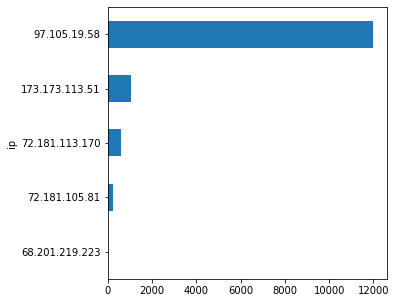

In [12]:
ip_df.set_index('ip')['count'].sort_values().tail(5).plot.barh(figsize=(5, 5))

### Conditional Probabilities
What is probability of a certain status code given an IP address?


HTTP Status Codes

200: ok
3xx: redirects
4xx: client level errors -- the requester did something wrong
5xx: server level errors -- the server did something wrong

In [13]:
Pab = df.groupby(['ip', 'status_code']).size()/len(df)
Pb = df.groupby('ip').size()/len(df)

Pab / Pb

ip              status_code
173.173.113.51  200            1.000000
24.26.242.9     200            1.000000
3.88.129.158    200            1.000000
3.92.201.136    200            1.000000
34.207.64.242   200            1.000000
34.229.70.250   200            1.000000
35.174.209.2    200            1.000000
35.175.171.137  200            1.000000
45.23.250.16    200            1.000000
52.87.230.102   200            1.000000
52.90.165.200   200            1.000000
52.91.30.150    200            1.000000
54.145.52.184   200            1.000000
54.172.14.223   200            1.000000
68.201.219.223  200            1.000000
70.121.214.34   200            1.000000
72.181.105.81   200            1.000000
72.181.113.170  200            0.996737
                499            0.003263
95.31.16.121    301            1.000000
95.31.18.119    200            1.000000
97.105.15.120   301            1.000000
97.105.19.58    200            0.998833
                499            0.001167
dtype: float

In [14]:
# Given a particular ip, what is probability of a certain status code
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [15]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


In [16]:
df[df.ip == '72.181.113.170'].sort_values(by='status_code')


,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 02:12:07,72.181.113.170,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-17 03:41:59,72.181.113.170,GET,/api/v1/sales?page=112,HTTP/1.1,200,510142,python-requests/2.21.0,0.486509
2019-04-17 03:42:01,72.181.113.170,GET,/api/v1/sales?page=113,HTTP/1.1,200,511094,python-requests/2.21.0,0.487417
2019-04-17 03:42:03,72.181.113.170,GET,/api/v1/sales?page=114,HTTP/1.1,200,511291,python-requests/2.21.0,0.487605
2019-04-17 03:42:05,72.181.113.170,GET,/api/v1/sales?page=115,HTTP/1.1,200,510140,python-requests/2.21.0,0.486507
...,...,...,...,...,...,...,...,...
2019-04-17 03:28:08,72.181.113.170,GET,/api/v1/sales?page=101,HTTP/1.1,200,510509,python-requests/2.21.0,0.486859
2019-04-17 03:28:11,72.181.113.170,GET,/api/v1/sales?page=102,HTTP/1.1,200,512612,python-requests/2.21.0,0.488865
2019-04-17 03:52:08,72.181.113.170,GET,/api/v1/sales?page=183,HTTP/1.1,200,308243,python-requests/2.21.0,0.293963
